In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import retrieval_311
import census_data_311
import geopandas as gpd
import contextily as cx
import os

In [2]:
df = retrieval_311.bulk_download_311()

Data available locally


In [3]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [4]:
# variables: https://api.census.gov/data/2019/acs/acs5/variables.html
hispanic = [f'B03002_0{i:02d}E' for i in range(1, 13)]
other_vars = ['B01003_001E',
              'B19013_001E', # median income
              'B01002_001E', # 
              'B25024_001E', # total structures
              'B25024_002E' # single family homes
              ]
fields = hispanic + other_vars
census_df = census_data_311.get_census_data(fields)
sf_df = census_data_311.clean_variable_names(census_df, fields)

In [6]:
shape_url = "https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip"
path = "sf_shapes/sf_county_farallon.shp"

sf_county_farallon = census_data_311.open_sf_shape(shape_url, path)

Opening local file...
Done


In [7]:
sf_merge = sf_county_farallon.merge(sf_df, on = "GEOID", how="inner")

In [8]:
sf_merge = sf_merge[sf_merge['Total'] >= 1]
gdf = gdf[gdf['Latitude'] != 0]

In [9]:
sf_merge.crs = "epsg:4326"
gdf.crs = "epsg:4326"

In [11]:
land_populated_df = census_data_311.remove_water(sf_merge)

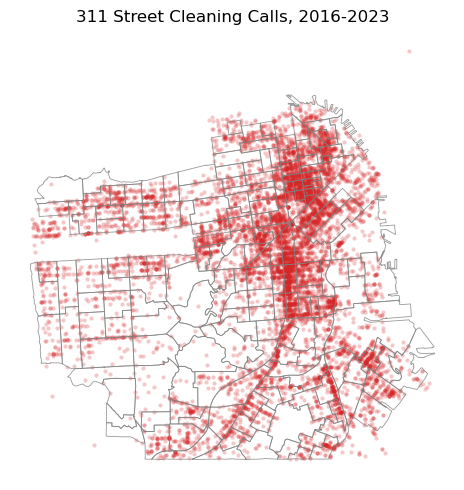

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("311 Street Cleaning Calls, 2016-2023")
land_populated_df.exterior.plot(linewidth=.6, color='grey', alpha=.8, ax=ax)
gdf.sample(10000).plot(ax=ax, color="tab:red", marker=".", alpha=.25, linewidth=0)
ax.set_axis_off()
fig.tight_layout()
fig.savefig("figures/311_map.png", dpi=300)

In [13]:
gdf

,Unnamed: 0,CaseID,Opened,Updated,Status,Responsible Agency,Category,Request Type,Latitude,Longitude,Point,Source,geometry
0,1,6484030,11/01/2016 11:26:26 AM,11/01/2016 04:59:33 PM,Closed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,37.787567,-122.411644,"(37.78756714, -122.41164398)",Phone,POINT (-122.41164 37.78757)
1,2,6505388,11/07/2016 11:08:09 AM,11/12/2016 04:40:17 PM,Closed,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,37.725494,-122.378495,"(37.725494, -122.378495)",Mobile/Open311,POINT (-122.37850 37.72549)
2,3,6504738,11/07/2016 09:41:28 AM,11/07/2016 11:11:06 AM,Closed,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,37.752313,-122.403489,"(37.752313, -122.403489)",Mobile/Open311,POINT (-122.40349 37.75231)
3,5,6477287,10/30/2016 08:56:49 PM,12/11/2016 05:25:45 PM,Closed,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,37.799809,-122.431122,"(37.79980939, -122.43112217)",Phone,POINT (-122.43112 37.79981)
4,8,6487358,11/02/2016 09:37:18 AM,11/02/2016 12:04:01 PM,Closed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,37.766585,-122.421087,"(37.76658481, -122.42108684)",Web,POINT (-122.42109 37.76658)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281475,6081332,16601961,03/28/2023 04:36:00 PM,03/28/2023 05:00:28 PM,Open,DPW Ops Queue,Street and Sidewalk Cleaning,Medical Waste,37.741135,-122.422538,"(37.7411355, -122.4225379)",Web,POINT (-122.42254 37.74114)
2281476,6081333,16607420,03/30/2023 07:58:00 AM,04/06/2023 07:19:26 PM,Open,DPW Ops Queue,Street and Sidewalk Cleaning,Medical Waste,37.790106,-122.414731,"(37.7901055, -122.4147311)",Mobile/Open311,POINT (-122.41473 37.79011)
2281477,6081340,16629164,04/04/2023 01:20:00 PM,04/06/2023 03:37:00 PM,Closed,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,37.756765,-122.506888,"(37.75676526, -122.50688776)",Mobile/Open311,POINT (-122.50689 37.75677)
2281478,6081349,16631146,04/05/2023 12:41:00 AM,04/05/2023 08:12:00 AM,Closed,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,37.785914,-122.418315,"(37.78591431, -122.41831522)",Phone,POINT (-122.41832 37.78591)


In [123]:
for col in land_populated_df.columns:
    if col.startswith("Total_Not_Hispanic_or_Latino"):
        land_populated_df[col+"%"] = land_populated_df[col] / land_populated_df['Total_Not_Hispanic_or_Latino']
    elif col.startswith("Total_Hispanic_or_Latino"):
        land_populated_df[col+"%"] = land_populated_df[col] / land_populated_df['Total']


In [124]:
jointracts = gpd.sjoin(left_df=gdf,
                       right_df=land_populated_df,
                       how='left')


In [125]:
result = gpd.GeoDataFrame({"count": jointracts.groupby('TRACTCE').size(),
                           "geometry": jointracts.groupby('TRACTCE')['geometry'].first()})

In [126]:
tract_count = (jointracts['TRACTCE']
               .value_counts()
               .reset_index()
               .rename({"TRACTCE": "Count"},axis=1)
               )

In [127]:
tract_count

,index,Count
0,020800,66731
1,020100,65727
2,017601,60067
3,017700,54768
4,017802,46771
...,...,...
190,033201,976
191,060100,974
192,033203,254
193,033204,155


In [152]:
merged_df = land_populated_df.merge(tract_count, left_on="TRACTCE", right_on="index")

In [153]:
merged_df.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'Total', 'Total_Not_Hispanic_or_Latino',
       'Total_Not_Hispanic_or_Latino_White_alone',
       'Total_Not_Hispanic_or_Latino_Black_or_African_American_alone',
       'Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone',
       'Total_Not_Hispanic_or_Latino_Asian_alone',
       'Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone',
       'Total_Not_Hispanic_or_Latino_Some_other_race_alone',
       'Total_Not_Hispanic_or_Latino_Two_or_more_races',
       'Total_Not_Hispanic_or_Latino_Two_or_more_races_Two_races_including_Some_other_race',
       'Total_Not_Hispanic_or_Latino_Two_or_more_races_Two_races_excluding_Some_other_race_and_three_or_more_races',
       'Total_Hispanic_or_Latino',
       'Median_household_income_in_the_past_12_months_(in_2019_inflation-adjusted_dollars)',
   

In [154]:
merged_df['Median_age_--_Total']

0      39.4
1      38.9
2      42.4
3      44.0
4      44.5
       ... 
190    40.9
191    41.3
192    34.3
193    43.7
194    41.2
Name: Median_age_--_Total, Length: 195, dtype: float64

In [155]:
merged_df = merged_df[merged_df['Median_household_income_in_the_past_12_months_(in_2019_inflation-adjusted_dollars)'] > 0]

In [163]:
merged_df['Median_age'] = merged_df['Median_age_--_Total']
merged_df["Income"] = merged_df['Median_household_income_in_the_past_12_months_(in_2019_inflation-adjusted_dollars)'] 
merged_df["Population_Density"] = merged_df['Total'] / merged_df['ALAND']
merged_df["Latinx_Black_Indigenous"] = merged_df['Total_Hispanic_or_Latino%']
    # merged_df['Total_Not_Hispanic_or_Latino_Black_or_African_American_alone%'] + \
    # merged_df['Total_Not_Hispanic_or_Latino_American_Indian_and_Alaska_Native_alone%']
merged_df['log_count'] = np.log(merged_df['Count'])

In [182]:
smf.OLS.from_formula("log_count ~ Latinx_Black_Indigenous + Median_age + Population_Density", data=merged_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_count   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     8.083
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           4.28e-05
Time:                        14:24:02   Log-Likelihood:                -253.17
No. Observations:                 194   AIC:                             514.3
Df Residuals:                     190   BIC:                             527.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.6747      0.461     18.835      0.000       7.766       9.583
Latinx_Black_Indigenous     0.3179      0.173      1.836      0.068      -0.024       0.659
Median_age                 -0.0038      0.011     -0.350      0.727      -0.025       0.018
Population_Density         53.6784     11.132      4.822      0.000      31.720      75.637
==============================================================================
Omnibus:                       52.017   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.654
Skew:                          -1.080   Prob(JB):                     3.54e-35
Kurtosis:                       6.868   Cond. No.                     6.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
smf.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_count   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              2210.
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                   5.66e-148
Time:                        14:09:31   Log-Likelihood:                         -355.34
No. Observations:                 194   AIC:                                      716.7
Df Residuals:                     191   BIC:                                      726.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Population_Density           95.2088     18.427      5.167      0.000      58.862     131.556
Total_Hispanic_or_Latino%     1.4064      0.276      5.103      0.000       0.863       1.950
Median_age_--_Total           0.1939      0.005     39.171      0.000       0.184       0.204
==============================================================================
Omnibus:                       30.669   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.688
Skew:                          -0.783   Prob(JB):                     2.97e-13
Kurtosis:                       5.164   Cond. No.                     6.75e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
import graphviz
from sklearn.model_selection import GridSearchCV

In [219]:
dec = tree.DecisionTreeRegressor(max_depth=3)
dec.fit(X, y)

DecisionTreeRegressor(max_depth=3)

In [246]:
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), {'max_depth': [1, 2, 3, 4, 5, 6]}, cv=2)

In [247]:
grid_search.fit(X, y)

GridSearchCV(cv=2, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6]})

In [252]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=2)

In [249]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003989,9.971857e-04,0.001497,0.000501,1,{'max_depth': 1},0.049146,-0.472816,-0.211835,0.260981,2
1,0.001998,9.988546e-04,0.001494,0.000502,2,{'max_depth': 2},0.162758,-0.529162,-0.183202,0.345960,1
2,0.001995,1.192093e-07,0.000997,0.000000,3,{'max_depth': 3},0.028626,-0.491324,-0.231349,0.259975,3
3,0.003490,5.010366e-04,0.001497,0.000498,4,{'max_depth': 4},0.044031,-0.508195,-0.232082,0.276113,4
4,0.001997,2.264977e-06,0.000995,0.000002,5,{'max_depth': 5},-0.153327,-0.584037,-0.368682,0.215355,5
5,0.002489,5.046129e-04,0.001496,0.000500,6,{'max_depth': 6},-0.211381,-0.699919,-0.455650,0.244269,6


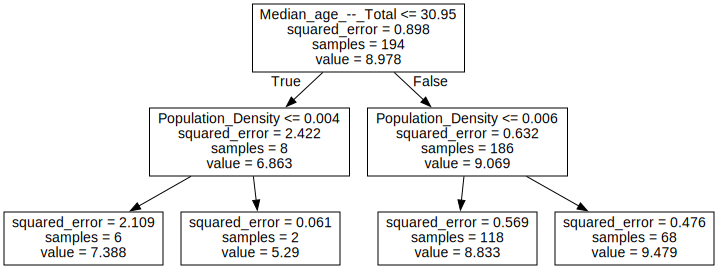

In [253]:
src = tree.export_graphviz(grid_search.best_estimator_, feature_names=X.columns)
graph = graphviz.Source(src)
graph

In [197]:
ols = LinearRegression()
ols.fit(X, y)

LinearRegression()

In [198]:
ols.score(X, y)

0.1131767832297117

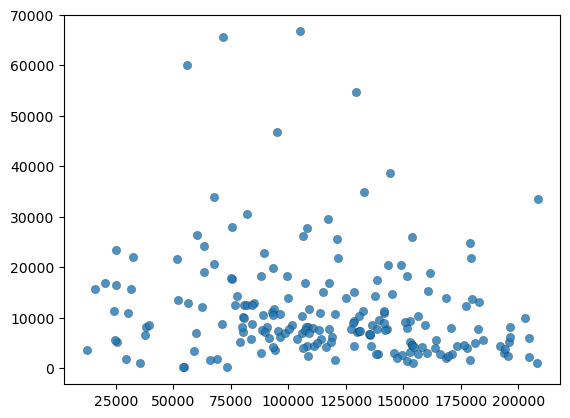

In [ ]:
fig, ax = plt.subplots()
ax.plot(merged_df['Median_household_income_in_the_past_12_months_(in_2019_inflation-adjusted_dollars)'],
        merged_df['Count'], ".",
        c="tab:blue",
        alpha=.8,
        markersize=12,
        markeredgecolor="black",
        markeredgewidth=.2)

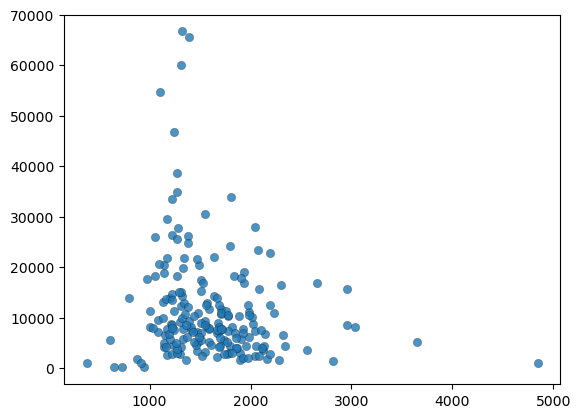

In [187]:
fig, ax = plt.subplots()
ax.plot(merged_df['Median_age_--_Total']**2, merged_df['Count'], ".",
        c="tab:blue",
        alpha=.8,
        markersize=12,
        markeredgecolor="black",
        markeredgewidth=.2)


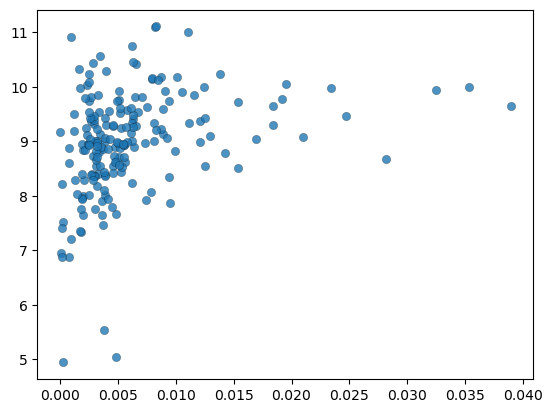

In [139]:
fig, ax = plt.subplots()
ax.plot(merged_df['Population_Density'], merged_df['log_count'], ".",
        c="tab:blue",
        alpha=.8,
        markersize=12,
        markeredgecolor="black",
        markeredgewidth=.2)


In [143]:
merged_df.corr()['log_count'].sort_values()

AWATER                                                                                                        -0.331920
ALAND                                                                                                         -0.280277
Total_Not_Hispanic_or_Latino_Some_other_race_alone%                                                           -0.255607
Total_1_detached                                                                                              -0.183402
Total_Not_Hispanic_or_Latino_Some_other_race_alone                                                            -0.144146
Income                                                                                                        -0.138614
Median_household_income_in_the_past_12_months_(in_2019_inflation-adjusted_dollars)                            -0.138614
Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone%                                -0.122861
Total_Not_Hispanic_or_Latino_Native_Hawa

In [140]:
(merged_df[['Count', 'Total', 'Income', 'Population_Density'] +
           [col for col in merged_df.columns if col.endswith("%")]]
 .corr()['Count']
 .sort_values()
 )

Income                                                                                                        -0.173384
Total_Not_Hispanic_or_Latino_Native_Hawaiian_and_Other_Pacific_Islander_alone%                                -0.081905
Total_Not_Hispanic_or_Latino_White_alone%                                                                     -0.030803
Total_Not_Hispanic_or_Latino_Asian_alone%                                                                      0.001966
Total_Not_Hispanic_or_Latino_Two_or_more_races_Two_races_excluding_Some_other_race_and_three_or_more_races%    0.003916
Total_Not_Hispanic_or_Latino_Some_other_race_alone%                                                            0.006139
Total_Not_Hispanic_or_Latino_Two_or_more_races%                                                                0.015719
Total_Not_Hispanic_or_Latino_Black_or_African_American_alone%                                                  0.063422
Total_Not_Hispanic_or_Latino_Two_or_more

In [256]:
from census import Census
from us import states

In [260]:
sf_census = retrieval_311.census_client.acs5.state_county_blockgroup(fields = fields,
                                            state_fips = states.CA.fips,
                                            county_fips = retrieval_311.sf_fips,
                                            blockgroup = "*",
                                            year = 2019)

In [263]:
pd.DataFrame(sf_census).columns

Index(['B03002_001E', 'B03002_002E', 'B03002_003E', 'B03002_004E',
       'B03002_005E', 'B03002_006E', 'B03002_007E', 'B03002_008E',
       'B03002_009E', 'B03002_010E', 'B03002_011E', 'B03002_012E',
       'B01003_001E', 'B19013_001E', 'B01002_001E', 'B25024_001E',
       'B25024_002E', 'state', 'county', 'tract', 'block group'],
      dtype='object')